# 구글 드라이브

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/빅데이터

/content/drive/MyDrive/빅데이터


# 데이터셋 가져오기

In [ ]:
from imutils import paths

search_dir = "AIhub_data"

image_paths = sorted(
    list(paths.list_images(search_dir))
)

print(">>> image count =", len(image_paths))

>>> image count = 1021


# Image와 Label 구별

In [ ]:
import os
import cv2
from tqdm import tqdm

image_dim = (320, 320, 3)

images = []
labels = []
for image_path in tqdm(image_paths):
    image = cv2.imread(image_path)

    image = cv2.resize(
        image, (image_dim[1], image_dim[0])
    )
    images.append(image)

    label = image_path.split(os.path.sep)[-2]
    labels.append([label])

    print(">>> images count =", len(images))

# 데이터 스케일링, 원 핫 코딩

In [ ]:
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

images = np.array(images, dtype='float32') / 255.0
labels = np.array(labels)

mlb = MultiLabelBinarizer()
enc_labels = mlb.fit_transform(labels)

print(">>> classes name =", mlb.classes_)

>>> classes name = ['0. stone' '1. pothole' '2. filled']


# 데이터 분할

In [ ]:
from sklearn.model_selection import train_test_split

seed = 47

(x_train, x_test, y_train, y_test) = train_test_split(
    images, enc_labels, test_size=0.1, random_state=seed
)
print(">> train test shape = {} {}".format(
    x_train.shape, x_test.shape)
)

>> train test shape = (918, 320, 320, 3) (103, 320, 320, 3)


# 모델 생성

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import BatchNormalization, Conv2D, Activation

inputs = keras.Input(shape=(320, 320, 3))
x = inputs
#x = layers.MaxPooling2D(2)(x)
_x = layers.Conv2D(64, 3, padding="same")(x)
_x = BatchNormalization()(_x)
_x = Activation('relu')(_x)
_x = layers.Conv2D(64, 3, padding="same")(_x)
_x = BatchNormalization()(_x)
_x = Activation('relu')(_x)
x = _x
_x = layers.Conv2D(64, 3, padding="same")(x)
_x = BatchNormalization()(_x)
_x = Activation('relu')(_x)
_x = layers.Conv2D(64, 3, padding="same")(_x)
_x = BatchNormalization()(_x)
_x = Activation('relu')(_x)
x = x + _x
x = layers.MaxPooling2D(2)(x)
_x = layers.Conv2D(64, 3, padding="same")(x)
_x = BatchNormalization()(_x)
_x = Activation('relu')(_x)
_x = layers.Conv2D(64, 3, padding="same")(_x)
_x = BatchNormalization()(_x)
_x = Activation('relu')(_x)
x = x + _x
x = layers.MaxPooling2D(2)(x)
_x = layers.Conv2D(64, 3, padding="same")(x)
_x = BatchNormalization()(_x)
_x = Activation('relu')(_x)
_x = layers.Conv2D(64, 3, padding="same")(_x)
_x = BatchNormalization()(_x)
_x = Activation('relu')(_x)
x = x + _x
x = layers.MaxPooling2D(2)(x)

x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Dense(3, activation='softmax')(x)
outputs = x

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 320, 320, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 320, 320, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

batch_size = 32
epoch = 100
learning_rate = 1e-3
decay = learning_rate / epoch

optimizer = Adam(
    learning_rate=learning_rate,
    decay=decay
)

loss = CategoricalCrossentropy(from_logits=False)

model.compile(
    loss=loss,
    optimizer=optimizer,
	metrics=['accuracy']
)

# 데이터 Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
    rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
    #rotation_range=25, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, horizontal_flip=True, fill_mode='nearest'
)

# 모델 학습

In [ ]:
history = model.fit_generator(
	aug.flow(
        x_train, y_train, batch_size=batch_size
    ),
	validation_data=(x_test, y_test),
	steps_per_epoch=len(x_train) // batch_size,
	epochs=epoch, verbose=1
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 320, 320, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 320, 320, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

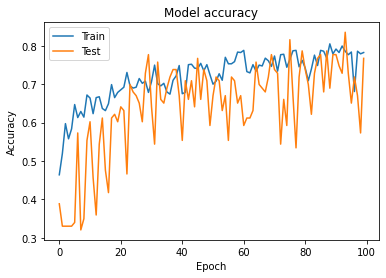

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

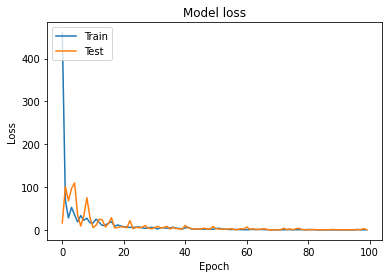

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.save("./saved_models_20183368/model_before_2.h5")

# Fine-tuning

In [ ]:
from keras.models import load_model
base_model = load_model("/content/drive/MyDrive/빅데이터/saved_models_20183368/model_before_2.h5")
base_model.trainable = True

In [ ]:
base_model.layers
len(base_model.layers)

34

In [ ]:
end_layer = 34
base_model.trainable = True
for layer in base_model.layers[ : 24 ] :
  layer.trainable = False

In [ ]:
for layer in model.layers[0:34]:
    print('Name:', layer.name, 'Trainable:', layer.trainable)

# 다시 학습

In [ ]:
from imutils import paths

search_dir = "Real_data"

image_paths = sorted(
    list(paths.list_images(search_dir))
)

print(">>> image count =", len(image_paths))

In [ ]:
import os
import cv2
from tqdm import tqdm

image_dim = (320, 320, 3)

images = []
labels = []
for image_path in tqdm(image_paths):
    image = cv2.imread(image_path)

    image = cv2.resize(
        image, (image_dim[1], image_dim[0])
    )
    images.append(image)

    label = image_path.split(os.path.sep)[-2]
    labels.append([label])

    print(">>> images count =", len(images))

In [ ]:
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

images = np.array(images, dtype='float32') / 255.0
labels = np.array(labels)

mlb = MultiLabelBinarizer()
enc_labels = mlb.fit_transform(labels)

print(">>> classes name =", mlb.classes_)

>>> classes name = ['0. no_pothole' '1. pothole' '2. filled']


In [ ]:
from sklearn.model_selection import train_test_split

seed = 47

(x_train, x_test, y_train, y_test) = train_test_split(
    images, enc_labels, test_size=0.1, random_state=seed
)
print(">> train test shape = {} {}".format(
    x_train.shape, x_test.shape)
)

>> train test shape = (243, 320, 320, 3) (28, 320, 320, 3)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
    rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
    #rotation_range=25, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, horizontal_flip=True, fill_mode='nearest'
)

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

batch_size = 32
epoch = 30
learning_rate = 1e-4
decay = learning_rate / epoch

optimizer = Adam(
    learning_rate=learning_rate,
    decay=decay
)

loss = CategoricalCrossentropy(from_logits=False)

base_model.compile(
    loss=loss,
    optimizer=optimizer,
	metrics=['accuracy']
)

In [ ]:
# 아까 학습한거에서 이어서 학습하도록 한다.
history_2 = base_model.fit_generator(
	aug.flow(
        x_train, y_train, batch_size=batch_size
    ),
	validation_data=(x_test, y_test),
	steps_per_epoch=len(x_train) // batch_size,
	epochs=epoch, verbose=1
)

In [ ]:
model.save("./saved_models_20183368/model_4.h5")